In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import pandas as pd
import xarray as xr
import glob
import os
from datetime import datetime, timedelta
from sklearn.metrics import r2_score

### Understanding INSAT data:

In [2]:
# loading sample file:
sfile = h5py.File("/home/gopika/Bela/GISE/mosdac_insat_lst/may/3RIMG_01MAY2017_0015_L2B_LST_V01R00.h5")

# list of variables
slist_of_vars = sfile.keys()
print(slist_of_vars)
print()

# attributes for each variable
slsts = sfile["LST"]
slats = sfile["Latitude"]
slons = sfile["Longitude"]
sgeoxs = sfile["GeoX"]
sgeoys = sfile["GeoY"]
varlist = [slsts, slats, slons, sgeoxs, sgeoys]
varnames = ["slsts", "slats", "slons", "sgeoxs", "sgeoys"]
for j in range(len(varlist)):
    attr_list = list(varlist[j].attrs)
    print(f"Variable - {varnames[j]}")
    for i in range(len(attr_list)):
        print(f"{attr_list[i]} --> {varlist[j].attrs[attr_list[i]]}\n\n")

# separating each variable
slsts = slsts[:]
slats = slats[:]
slons = slons[:]
sgeoxs = sgeoxs[:]
sgeoys = sgeoys[:]

# shape of each variable
for i in range(len(varnames)):
    print(f"Shape of {varnames[i]} is {varlist[i].shape}\n\n")
    
# reshaping variables where necessary
slsts1 = np.squeeze(slsts)

# locating the position of jaisalmer (lat, lon) in terms of geox, geoy
# jaisalmer lat = 26.99, lon = 71.34
jai_lat_val = 26.99
jai_lon_val = 71.34
found = False
for geoy in sgeoys:
    for geox in sgeoxs:
        lat = slats[geoy][geox]
        lon = slons[geoy][geox]

        if lat == 2699 and lon == 7134:
            found = True
            break
    if found:
        break
jai_geox = geox
jai_geoy = geoy

if found:
    print(f"Jaisalmer found at GeoX={jai_geox}, GeoY={jai_geoy}")
    # extracting LST value at this position:
    print(f"LST at jaisalmer is {slsts1[jai_geoy][jai_geox]}\n\n")
else:
    dist = (slats*0.01 - jai_lat_val)**2 + (slons*0.01 - jai_lon_val)**2
    # Find the nearest gridcell
    geoy, geox = np.unravel_index(np.argmin(dist), dist.shape)
    print(f"Nearest gridcell for Jaisalmer: GeoX={geox}, GeoY={geoy}\n\n")
    print(f"Latitude={slats[geoy][geox]*0.01}, Longitude={slons[geoy][geox]*0.01}")
    print(f"LST={slsts1[geoy, geox]}")
    jai_geox = geox
    jai_geoy = geoy

# next, defining a range of values of geox and geoy so that a region around jaisalmer with similar LULC (~LST) is determined
# for when LST value at the nearest gridcell is missing (_FillValue)
# spatial resolution of INSAT = 0.01 deg (1km)
# extent: ~20 km on either side; so GeoX [1371, 1357], GeoY [685, 725]

<KeysViewHDF5 ['GeoX', 'GeoY', 'LST', 'Latitude', 'Longitude', 'time']>

Variable - slsts
DIMENSION_LIST --> [array([<HDF5 object reference>], dtype=object)
 array([<HDF5 object reference>], dtype=object)
 array([<HDF5 object reference>], dtype=object)]


_FillValue --> [-999.]


coordinates --> b'time Latitude Longitude'


long_name --> b'Land Surface Temperature'


standard_name --> b'Land Surface Temperature'


units --> b'K'


Variable - slats
DIMENSION_LIST --> [array([<HDF5 object reference>], dtype=object)
 array([<HDF5 object reference>], dtype=object)]


_FillValue --> [32767]


add_offset --> [0.]


long_name --> b'latitude'


scale_factor --> [0.01]


standard_name --> b'latitude'


units --> b'degrees_north'


Variable - slons
DIMENSION_LIST --> [array([<HDF5 object reference>], dtype=object)
 array([<HDF5 object reference>], dtype=object)]


_FillValue --> [32767]


add_offset --> [0.]


long_name --> b'longitude'


scale_factor --> [0.01]


standard_name --> b'longitude'


### Loading original station data

In [3]:
# loading observational data so that i can merge the new LST data into it
df_station_data = pd.read_excel("/home/gopika/Bela/GISE/JSM_SH_WS_2017_infused.xlsx")

In [4]:
df_station_data

YEAR    DAY    HOUR  roundedhr    TA     PR   WS     WD  SHF  \
0      2017.0    1.0   0.250       0.25  12.1  995.8  0.8  130.0  0.0   
1      2017.0    1.0   0.499       0.50  11.6  995.7  1.2  136.0  0.0   
2      2017.0    1.0   0.751       0.75  11.2  995.5  1.3  141.0  0.0   
3      2017.0    1.0   1.001       1.00  10.7  995.4  1.6  139.0 -1.0   
4      2017.0    1.0   1.250       1.25  10.2  995.3  1.1  120.0 -2.0   
...       ...    ...     ...        ...   ...    ...  ...    ...  ...   
35034  2017.0  365.0  22.750      22.75  15.8  994.1  0.5  105.0  2.0   
35035  2017.0  365.0  23.000      23.00  14.6  994.0  0.6  324.0  0.0   
35036  2017.0  365.0  23.251      23.25  15.2  994.0  0.6    4.0 -2.0   
35037  2017.0  365.0  23.500      23.50  15.0  994.0  0.3   88.0  0.0   
35038  2017.0  365.0  23.750      23.75  14.2  993.8  0.3   66.0 -2.0   

       hour_num  hournum          test  test2  test3    TA_K  
0          0.25     0.25  awesomesauce    1.0    NaN  285.25  
1          0.50     0.50             1    2.0    NaN  284.75  
2          0.75     0.75             1    3.0    NaN  284.35  
3          1.00     1.00             1    4.0    NaN  283.85  
4          1.25     1.25             1    5.0    NaN  283.35  
...         ...      ...           ...    ...    ...     ...  
35034   8758.75  8491.25           365   92.0    NaN  288.95  
35035   8759.00  8491.50           365   93.0    NaN  287.75  
35036   8759.25  8491.75           365   94.0    NaN  288.35  
35037   8759.50  8492.00           365   95.0    NaN  288.15  
35038   8759.75  8492.25           365   96.0   96.0  287.35  

[35039 rows x 15 columns]

In [5]:
# splitting above dataframe month-wise.
month_days = [31,28,31,30,31,30,31,31,30,31,30,31]
cum_month_days = np.cumsum(month_days)

# Function to map day-of-year to month number
def day_to_month(day):
    return np.searchsorted(cum_month_days, day) + 1
    
# Add a new column "MONTH"
df_station_data["MONTH"] = df_station_data["DAY"].apply(day_to_month)

# splitting original dataframe into different months
dfs_by_month = [df_station_data[df_station_data["MONTH"] == m] for m in range(1, 13)]

In [6]:
dfs_by_month

[        YEAR   DAY    HOUR  roundedhr    TA     PR   WS     WD   SHF  \
 0     2017.0   1.0   0.250       0.25  12.1  995.8  0.8  130.0   0.0   
 1     2017.0   1.0   0.499       0.50  11.6  995.7  1.2  136.0   0.0   
 2     2017.0   1.0   0.751       0.75  11.2  995.5  1.3  141.0   0.0   
 3     2017.0   1.0   1.001       1.00  10.7  995.4  1.6  139.0  -1.0   
 4     2017.0   1.0   1.250       1.25  10.2  995.3  1.1  120.0  -2.0   
 ...      ...   ...     ...        ...   ...    ...  ...    ...   ...   
 2970  2017.0  31.0  22.750      22.75  17.8  997.5  2.2   90.0 -25.0   
 2971  2017.0  31.0  22.999      23.00  17.3  997.5  2.2   86.0 -20.0   
 2972  2017.0  31.0  23.251      23.25  16.8  997.4  2.3   87.0 -19.0   
 2973  2017.0  31.0  23.501      23.50  16.4  997.4  2.1   99.0 -18.0   
 2974  2017.0  31.0  23.750      23.75  16.2  997.3  2.0  103.0  -6.0   
 
       hour_num  hournum          test  test2  test3    TA_K  MONTH  
 0         0.25     0.25  awesomesauce    1.0    NaN

### Processing INSAT data

In [7]:
month_names = ["January","February","March","April","May","June",
             "July","August","September","October","November","December"]

month_snames = ["jan", "feb", "mar", "apr","may", "jun", "jul", "aug", "sept", "oct", "nov", "dec"]

In [8]:
# Folder with my files
files_by_month = []
for month in month_snames:
    folder = f"/home/gopika/Bela/GISE/mosdac_insat_lst/{month}"
    # getting all .h5 files
    files = sorted(glob.glob(os.path.join(folder, "*.h5")))
    files_by_month.append(files)

In [9]:
len(files_by_month[1])

1200

In [10]:
type(files_by_month)

list

In [11]:
df_insat_LST_monthwise = []
for files in files_by_month:
    # empty dataframe with LST information
    df_insat_LST = pd.DataFrame(columns=["YEAR", "DAY", "roundedhr", "LST"])
    for file in files:
    
        filename = os.path.basename(file) 
        
        # extracting the datetime info
        date_str = filename.split("_")[1]
        time_str = filename.split("_")[2]
        
        # converting to IST - YEAR, DAY(-OF-YEAR), HOUR
        dt_gmt = datetime.strptime(date_str + time_str, "%d%b%Y%H%M")
        dt_ist = dt_gmt + timedelta(hours=5, minutes=30)
        day_of_year = dt_ist.timetuple().tm_yday
        year = dt_ist.year
        day = day_of_year
        hour = dt_ist.hour + dt_ist.minute/60
        
        # extracting the LST at jaisalmer
        ds = h5py.File(file)
        lst = ds["LST"][:]
        lst1 = np.squeeze(lst)
        lst1 = np.where(lst1 == -999, np.nan, lst1)
    
        lstemp = lst1[jai_geoy][jai_geox]
        
        # handling nan / missing value here
        if np.isnan(lstemp):
            geoy_start, geoy_end = 1357, 1371
            geox_start, geox_end = 685, 725
            region_values = lst1[geoy_start:geoy_end+1, geox_start:geox_end+1]
            lstemp = np.nanmean(region_values)
    
        # adding to the new dataframe
        df_insat_LST.loc[len(df_insat_LST)] = [year, day, hour, lstemp]

    df_insat_LST_monthwise.append(df_insat_LST)

/tmp/ipykernel_1125878/913392265.py:34: RuntimeWarning: Mean of empty slice
  lstemp = np.nanmean(region_values)
/tmp/ipykernel_1125878/913392265.py:34: RuntimeWarning: Mean of empty slice
  lstemp = np.nanmean(region_values)
/tmp/ipykernel_1125878/913392265.py:34: RuntimeWarning: Mean of empty slice
  lstemp = np.nanmean(region_values)
/tmp/ipykernel_1125878/913392265.py:34: RuntimeWarning: Mean of empty slice
  lstemp = np.nanmean(region_values)
/tmp/ipykernel_1125878/913392265.py:34: RuntimeWarning: Mean of empty slice
  lstemp = np.nanmean(region_values)
/tmp/ipykernel_1125878/913392265.py:34: RuntimeWarning: Mean of empty slice
  lstemp = np.nanmean(region_values)
/tmp/ipykernel_1125878/913392265.py:34: RuntimeWarning: Mean of empty slice
  lstemp = np.nanmean(region_values)
/tmp/ipykernel_1125878/913392265.py:34: RuntimeWarning: Mean of empty slice
  lstemp = np.nanmean(region_values)
/tmp/ipykernel_1125878/913392265.py:34: RuntimeWarning: Mean of empty slice
  lstemp = np.nanmea

In [12]:
len(df_insat_LST_monthwise)

12

### Merging INSAT data with station observations

In [13]:
# merging LST with the remaining observed data
merged_obsv_monthwise = []
for i in range(12):
    merged_obsv = pd.merge(
        dfs_by_month[i],
        df_insat_LST_monthwise[i][["YEAR", "DAY", "roundedhr", "LST"]],
        on=["YEAR", "DAY", "roundedhr"],
        how="outer"
    )
    
    merged_obsv = merged_obsv.sort_values(by=["YEAR", "DAY", "roundedhr"]).reset_index(drop=True)
    merged_obsv_monthwise.append(merged_obsv)

    merged_obsv.to_excel(f"/home/gopika/Bela/GISE/mosdac_insat_lst/JSM_SH_WS_2017_infused_{month_snames[i]}_LST.xlsx", index=False)

In [14]:
merged_obsv_monthwise[1]

YEAR   DAY    HOUR  roundedhr    TA     PR   WS     WD   SHF  \
0     2017.0  32.0   0.000       0.00  16.1  997.1  1.6  117.0  -7.0   
1     2017.0  32.0   0.250       0.25  15.4  996.9  0.6  145.0   2.0   
2     2017.0  32.0   0.499       0.50  15.0  996.8  0.2  261.0   0.0   
3     2017.0  32.0   0.751       0.75  14.8  996.6  0.3  264.0  -1.0   
4     2017.0  32.0   1.001       1.00  14.9  996.6  0.2   20.0   0.0   
...      ...   ...     ...        ...   ...    ...  ...    ...   ...   
2562  2017.0  59.0  22.750      22.75  24.5  994.8  2.3   74.0 -37.0   
2563  2017.0  59.0  22.999      23.00  24.3  994.9  1.7   55.0  -8.0   
2564  2017.0  59.0  23.251      23.25  24.5  994.9  2.3   53.0 -24.0   
2565  2017.0  59.0  23.501      23.50  24.3  994.9  2.2   51.0 -26.0   
2566  2017.0  59.0  23.750      23.75  24.0  994.9  2.1   56.0 -24.0   

      hour_num  hournum          test  test2  test3    TA_K  MONTH         LST  
0       744.00   686.75  awesomesauce    1.0    NaN  289.25    2.0         NaN  
1       744.25   687.00            32    2.0    NaN  288.55    2.0         NaN  
2       744.50   687.25            32    3.0    NaN  288.15    2.0         NaN  
3       744.75   687.50            32    4.0    NaN  287.95    2.0         NaN  
4       745.00   687.75            32    5.0    NaN  288.05    2.0         NaN  
...        ...      ...           ...    ...    ...     ...    ...         ...  
2562   1414.75  1303.00            59   83.0    NaN  297.65    2.0         NaN  
2563   1415.00  1303.25            59   84.0    NaN  297.45    2.0         NaN  
2564   1415.25  1303.50            59   85.0    NaN  297.65    2.0  286.597565  
2565   1415.50  1303.75            59   86.0    NaN  297.45    2.0         NaN  
2566   1415.75  1304.00            59   87.0   87.0  297.15    2.0         NaN  

[2567 rows x 17 columns]

### Determining R2 of DT with SHF in Townsend regime

In [15]:
# preparing each month's data frame and computing r2 for each 2-hour slot:

r2_monthwise_lists = []
for merged_obsv in merged_obsv_monthwise:
    r2_list = []
    # retaining only certain columns:
    merged_obsv = merged_obsv[["YEAR", "MONTH", "DAY", "roundedhr", "TA_K", "LST", "SHF"]]

    # introducing column for temperature differential
    merged_obsv = merged_obsv.copy()
    merged_obsv["DT"] = merged_obsv["LST"] - merged_obsv["TA_K"]    

    df_0_2 = merged_obsv[(0<=merged_obsv['roundedhr']) & (merged_obsv['roundedhr']<2)]
    df_2_4 = merged_obsv[(2<=merged_obsv['roundedhr']) & (merged_obsv['roundedhr']<4)]
    df_4_6 = merged_obsv[(4<=merged_obsv['roundedhr']) & (merged_obsv['roundedhr']<6)]
    df_6_8 = merged_obsv[(6<=merged_obsv['roundedhr']) & (merged_obsv['roundedhr']<8)]
    df_8_10 = merged_obsv[(8<=merged_obsv['roundedhr']) & (merged_obsv['roundedhr']<10)]
    df_10_12 = merged_obsv[(10<=merged_obsv['roundedhr']) & (merged_obsv['roundedhr']<12)]
    df_12_14 = merged_obsv[(12<=merged_obsv['roundedhr']) & (merged_obsv['roundedhr']<14)]
    df_14_16 = merged_obsv[(14<=merged_obsv['roundedhr']) & (merged_obsv['roundedhr']<16)]
    df_16_18 = merged_obsv[(16<=merged_obsv['roundedhr']) & (merged_obsv['roundedhr']<18)]
    df_18_20 = merged_obsv[(18<=merged_obsv['roundedhr']) & (merged_obsv['roundedhr']<20)]
    df_20_22 = merged_obsv[(20<=merged_obsv['roundedhr']) & (merged_obsv['roundedhr']<22)]
    df_22_24 = merged_obsv[(22<=merged_obsv['roundedhr']) & (merged_obsv['roundedhr']<24)]

    df_2_hr = [df_0_2, df_2_4, df_4_6, df_6_8, df_8_10, df_10_12,
               df_12_14, df_14_16, df_16_18, df_18_20, df_20_22, df_22_24]

    for i in range(len(df_2_hr)):
        xp = np.array(df_2_hr[i]["SHF"])
        yp = (np.array(df_2_hr[i]["DT"])**4)**(1/3)

        mask = ~np.isnan(xp) & ~np.isnan(yp)
        xp, yp = xp[mask], yp[mask]
        
        if len(xp) > 1 and np.std(xp) > 0:
            n, b = np.polyfit(xp, yp, 1)
            r2 = r2_score(yp, n*xp+b)
        else:
            r2 = np.nan

        r2_list.append(r2)
    r2_monthwise_lists.append(r2_list)   

### Plotting to compare with ERA5

In [16]:
# loading EAR5 data for a decade

# TEMPERATURE AT 2M
ds_t2m = xr.open_dataset('/home/gopika/Bela/GISE/2m_temp/2m_temp.nc')

# TEMPERATURE AT SFC
ds_for_tsfc_2014 = xr.open_dataset('/home/gopika/Bela/GISE/temp_sfc/2014.nc')
ds_for_tsfc_2015 = xr.open_dataset('/home/gopika/Bela/GISE/temp_sfc/2015.nc')
ds_for_tsfc_2016 = xr.open_dataset('/home/gopika/Bela/GISE/temp_sfc/2016.nc')
ds_for_tsfc_2017 = xr.open_dataset('/home/gopika/Bela/GISE/temp_sfc/2017.nc')
ds_for_tsfc_2018 = xr.open_dataset('/home/gopika/Bela/GISE/temp_sfc/2018.nc')
ds_for_tsfc_2019 = xr.open_dataset('/home/gopika/Bela/GISE/temp_sfc/2019.nc')
ds_for_tsfc_2020 = xr.open_dataset('/home/gopika/Bela/GISE/temp_sfc/2020.nc')
ds_for_tsfc_2021 = xr.open_dataset('/home/gopika/Bela/GISE/temp_sfc/2021.nc')
ds_for_tsfc_2022 = xr.open_dataset('/home/gopika/Bela/GISE/temp_sfc/2022.nc')
ds_for_tsfc_2023 = xr.open_dataset('/home/gopika/Bela/GISE/temp_sfc/2023.nc')

# DATASET CONTAINING SHF
ds_for_shf_2014 = xr.open_dataset('/home/gopika/Bela/GISE/blh_sshf_slhf_u100/2014.nc')
ds_for_shf_2015 = xr.open_dataset('/home/gopika/Bela/GISE/blh_sshf_slhf_u100/2015.nc')
ds_for_shf_2016 = xr.open_dataset('/home/gopika/Bela/GISE/blh_sshf_slhf_u100/2016.nc')
ds_for_shf_2017 = xr.open_dataset('/home/gopika/Bela/GISE/blh_sshf_slhf_u100/2017.nc')
ds_for_shf_2018 = xr.open_dataset('/home/gopika/Bela/GISE/blh_sshf_slhf_u100/2018.nc')
ds_for_shf_2019 = xr.open_dataset('/home/gopika/Bela/GISE/blh_sshf_slhf_u100/2019.nc')
ds_for_shf_2020 = xr.open_dataset('/home/gopika/Bela/GISE/blh_sshf_slhf_u100/2020.nc')
ds_for_shf_2021 = xr.open_dataset('/home/gopika/Bela/GISE/blh_sshf_slhf_u100/2021.nc')
ds_for_shf_2022 = xr.open_dataset('/home/gopika/Bela/GISE/blh_sshf_slhf_u100/2022.nc')
ds_for_shf_2023 = xr.open_dataset('/home/gopika/Bela/GISE/blh_sshf_slhf_u100/2023.nc')

In [17]:
# separating SHF from the dataset
ds_shf_2014 = ds_for_shf_2014.sshf/(-3600)
ds_shf_2015 = ds_for_shf_2015.sshf/(-3600)
ds_shf_2016 = ds_for_shf_2016.sshf/(-3600)
ds_shf_2017 = ds_for_shf_2017.sshf/(-3600)
ds_shf_2018 = ds_for_shf_2018.sshf/(-3600)
ds_shf_2019 = ds_for_shf_2019.sshf/(-3600)
ds_shf_2020 = ds_for_shf_2020.sshf/(-3600)
ds_shf_2021 = ds_for_shf_2021.sshf/(-3600)
ds_shf_2022 = ds_for_shf_2022.sshf/(-3600)
ds_shf_2023 = ds_for_shf_2023.sshf/(-3600)

ds_t2m = ds_t2m.t2m

ds_sfc_2014 = ds_for_tsfc_2014.skt
ds_sfc_2015 = ds_for_tsfc_2015.skt
ds_sfc_2016 = ds_for_tsfc_2016.skt
ds_sfc_2017 = ds_for_tsfc_2017.skt
ds_sfc_2018 = ds_for_tsfc_2018.skt
ds_sfc_2019 = ds_for_tsfc_2019.skt
ds_sfc_2020 = ds_for_tsfc_2020.skt
ds_sfc_2021 = ds_for_tsfc_2021.skt
ds_sfc_2022 = ds_for_tsfc_2022.skt
ds_sfc_2023 = ds_for_tsfc_2023.skt

In [18]:
ds_t2m_2014 = ds_t2m.sel(valid_time=ds_t2m.valid_time.dt.year == 2014)
ds_t2m_2015 = ds_t2m.sel(valid_time=ds_t2m.valid_time.dt.year == 2015)
ds_t2m_2016 = ds_t2m.sel(valid_time=ds_t2m.valid_time.dt.year == 2016)
ds_t2m_2017 = ds_t2m.sel(valid_time=ds_t2m.valid_time.dt.year == 2017)
ds_t2m_2018 = ds_t2m.sel(valid_time=ds_t2m.valid_time.dt.year == 2018)
ds_t2m_2019 = ds_t2m.sel(valid_time=ds_t2m.valid_time.dt.year == 2019)
ds_t2m_2020 = ds_t2m.sel(valid_time=ds_t2m.valid_time.dt.year == 2020)
ds_t2m_2021 = ds_t2m.sel(valid_time=ds_t2m.valid_time.dt.year == 2021)
ds_t2m_2022 = ds_t2m.sel(valid_time=ds_t2m.valid_time.dt.year == 2022)
ds_t2m_2023 = ds_t2m.sel(valid_time=ds_t2m.valid_time.dt.year == 2023)

In [19]:
# extracting the jaisalmer region:

## make list of the datasets whose regions have to be extracted:
datasets = [ds_shf_2014, ds_shf_2015, ds_shf_2016, ds_shf_2017, ds_shf_2018, ds_shf_2019, ds_shf_2020, ds_shf_2021, ds_shf_2022, ds_shf_2023,
           ds_t2m_2014, ds_t2m_2015, ds_t2m_2016, ds_t2m_2017, ds_t2m_2018, ds_t2m_2019, ds_t2m_2020, ds_t2m_2021, ds_t2m_2022, ds_t2m_2023,
           ds_sfc_2014, ds_sfc_2015, ds_sfc_2016, ds_sfc_2017, ds_sfc_2018, ds_sfc_2019, ds_sfc_2020, ds_sfc_2021, ds_sfc_2022, ds_sfc_2023]
datasets_jai_shf = []
datasets_jai_t2m = []
datasets_jai_sfc = []
for i in range(0,10):
    ds_jai_point = datasets[i].sel(latitude=26.91, longitude=70.90, method = 'nearest')
    datasets_jai_shf.append(ds_jai_point)
for i in range(10,20):
    ds_jai_point = datasets[i].sel(latitude=26.91, longitude=70.90, method = 'nearest')
    datasets_jai_t2m.append(ds_jai_point)
for i in range(20,30):
    ds_jai_point = datasets[i].sel(latitude=26.91, longitude=70.90, method = 'nearest')
    datasets_jai_sfc.append(ds_jai_point)
    

In [20]:
# time zone fixing for each, this is just replacing each element by its corresponding time-corrected version:
for i in range(len(datasets_jai_shf)):
    datasets_jai_shf[i]['valid_time'] = datasets_jai_shf[i]['valid_time'] + pd.Timedelta(hours=5, minutes=30)
for i in range(len(datasets_jai_t2m)):
    datasets_jai_t2m[i]['valid_time'] = datasets_jai_t2m[i]['valid_time'] + pd.Timedelta(hours=5, minutes=30)
for i in range(len(datasets_jai_sfc)):
    datasets_jai_sfc[i]['valid_time'] = datasets_jai_sfc[i]['valid_time'] + pd.Timedelta(hours=5, minutes=30)

In [21]:
datasets_jai_deltatemp = []
for i in range(10):
    diff = datasets_jai_sfc[i] - datasets_jai_t2m[i]
    datasets_jai_deltatemp.append(diff)

In [22]:
years = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
slot_hour = [1,3,5,7,9,11,13,15,17,19,21,23]

In [23]:
shf_months_by_yr = []
dtemp_months_by_yr = []
for j in range(1,13):
    a_month_shf = []
    a_month_dtemp = []
    for i in range(10):
        a_month_shf.append(datasets_jai_shf[i].where(datasets_jai_shf[i]['valid_time'].dt.month == j, drop=True))
        a_month_dtemp.append(datasets_jai_deltatemp[i].where(datasets_jai_deltatemp[i]['valid_time'].dt.month == j, drop=True))
    shf_months_by_yr.append(a_month_shf)
    dtemp_months_by_yr.append(a_month_dtemp)

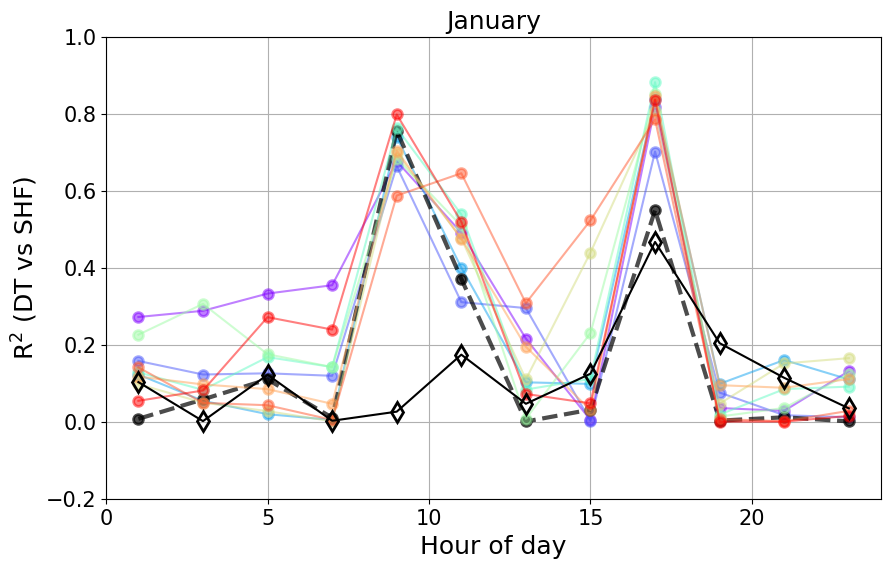

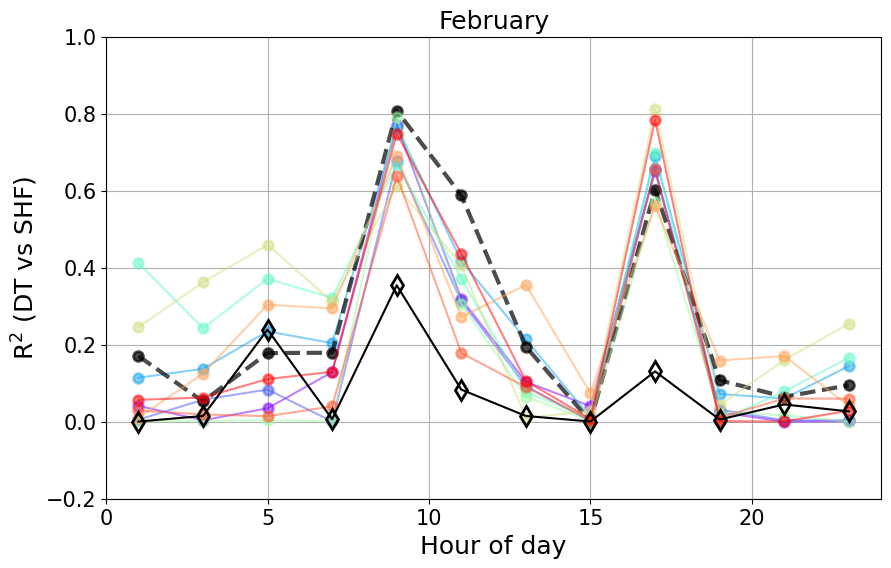

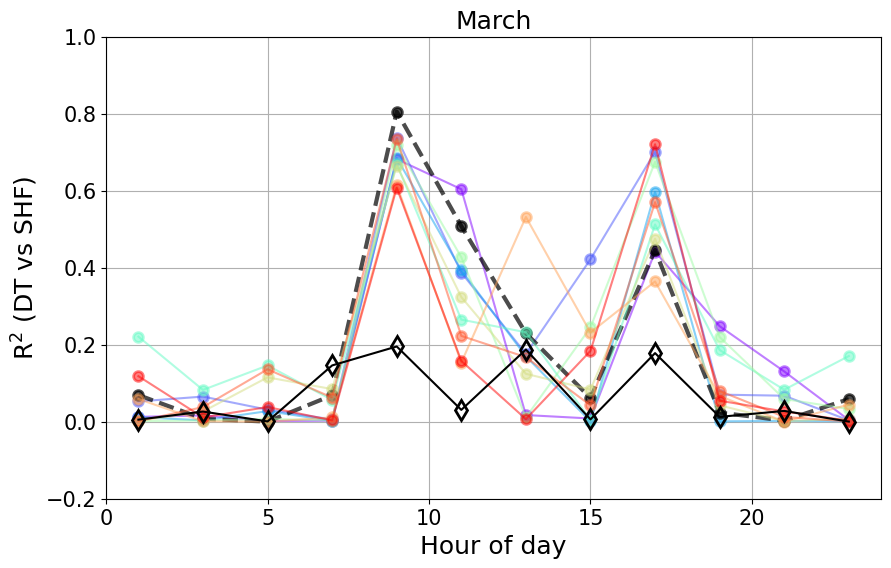

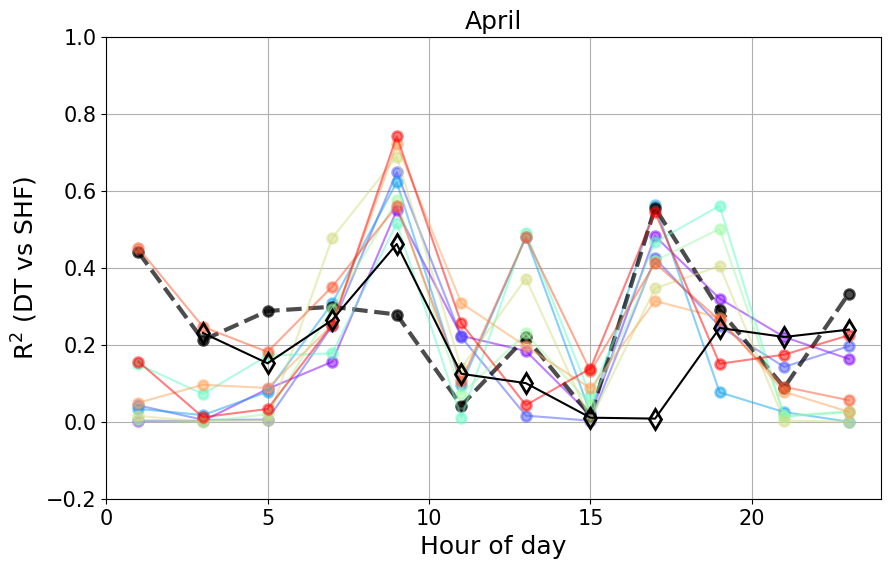

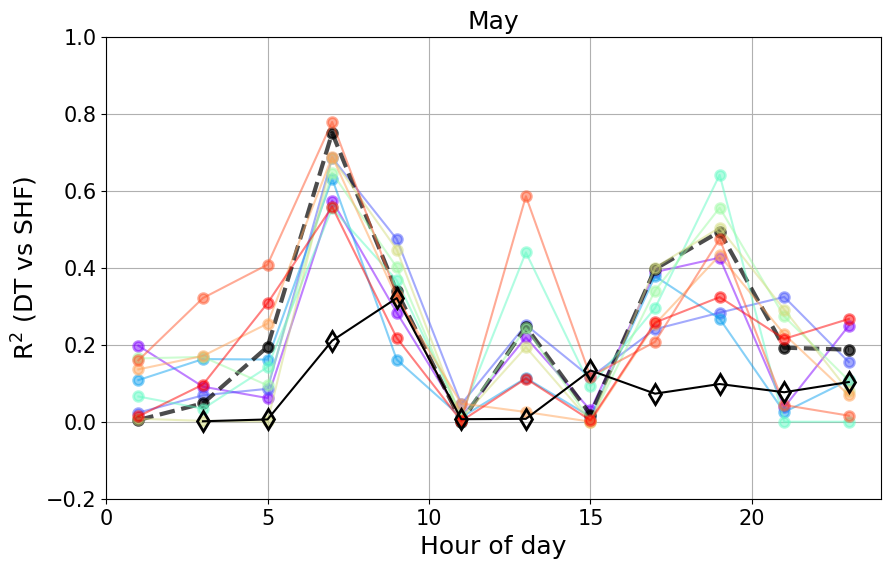

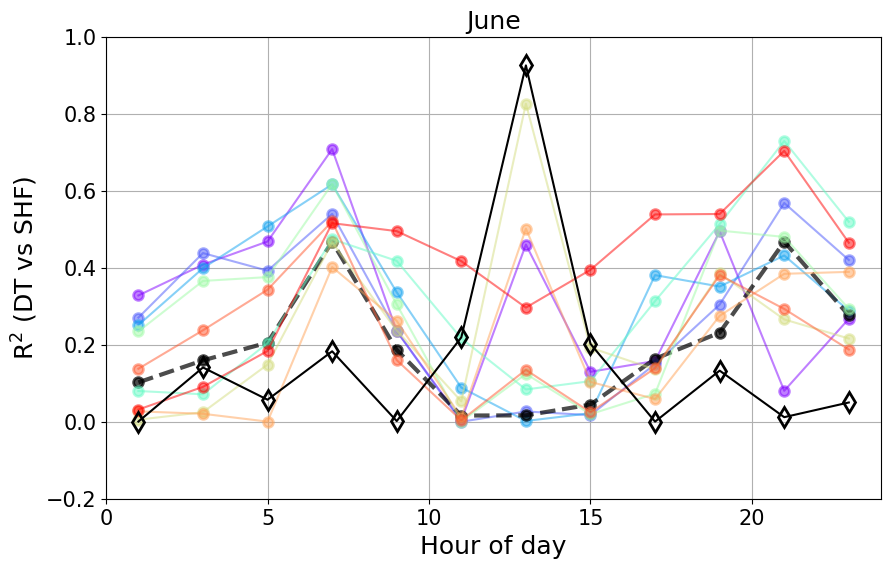

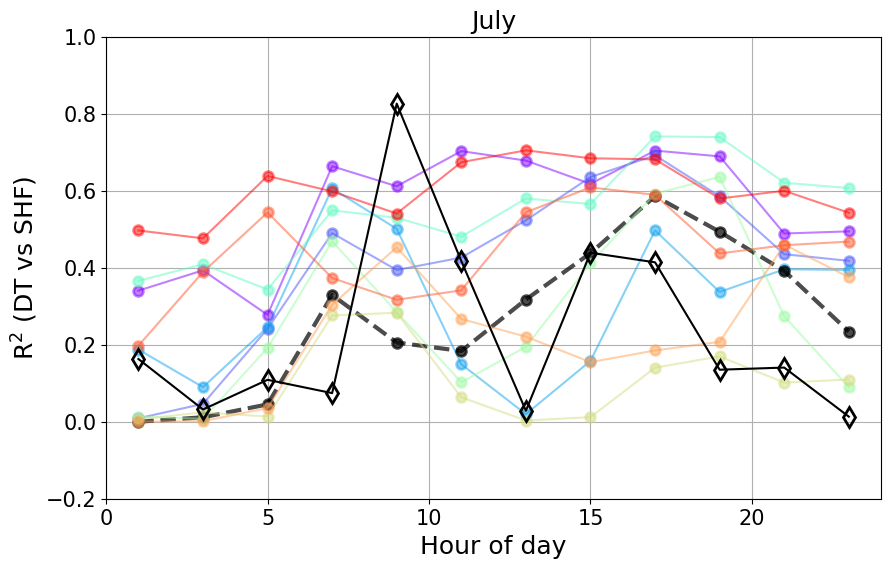

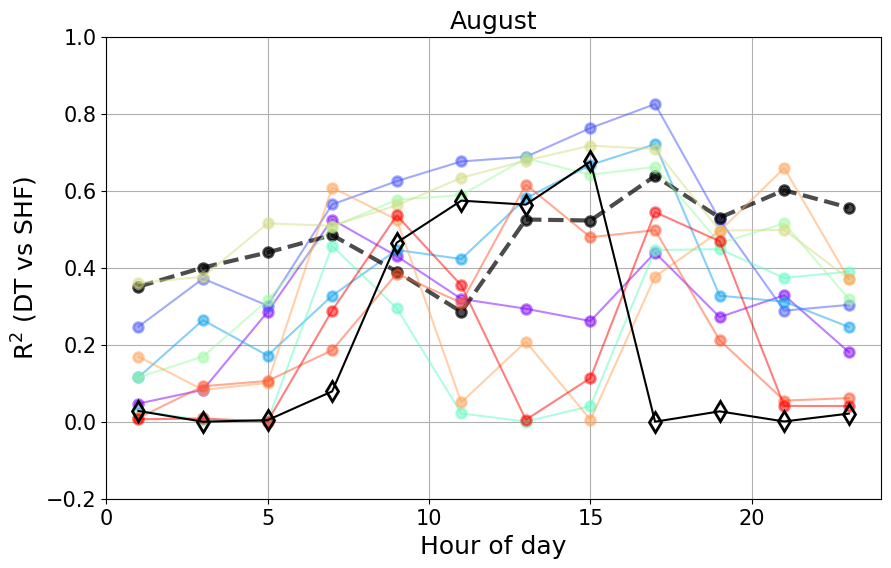

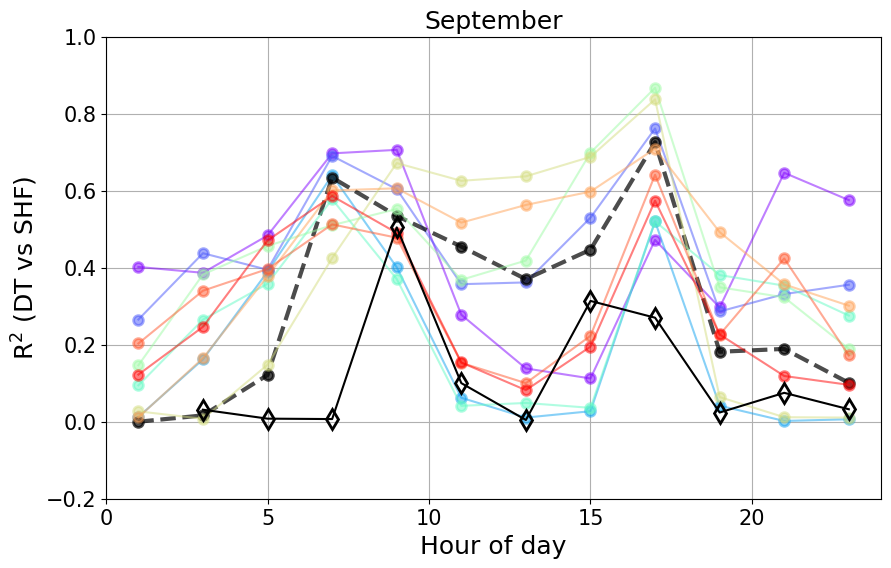

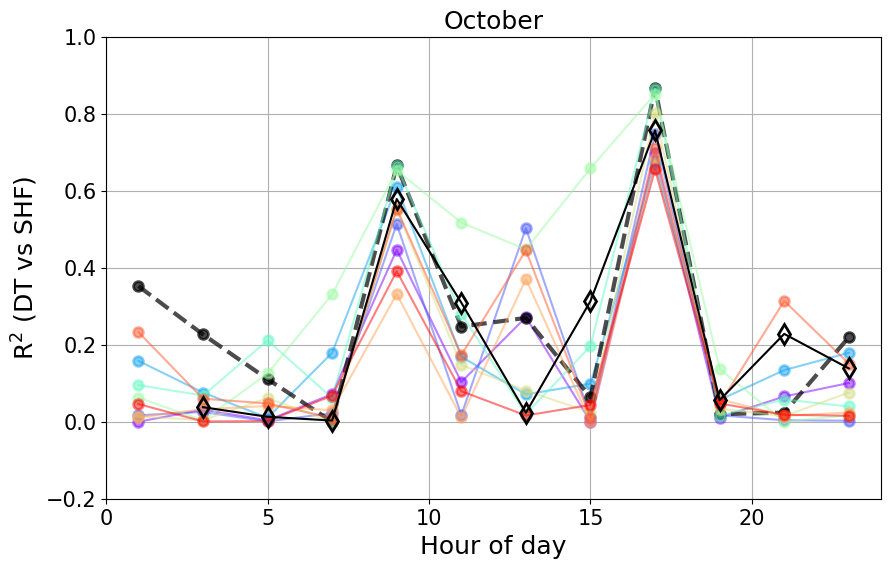

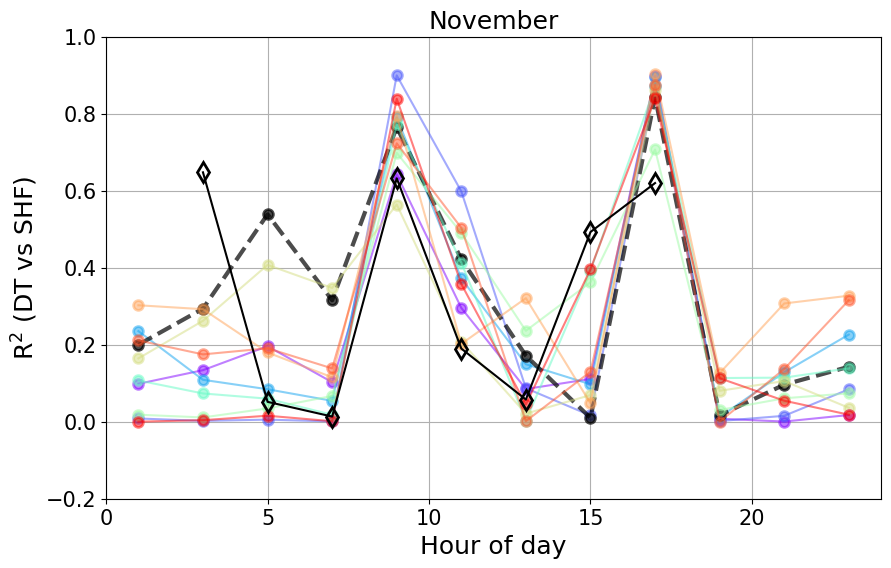

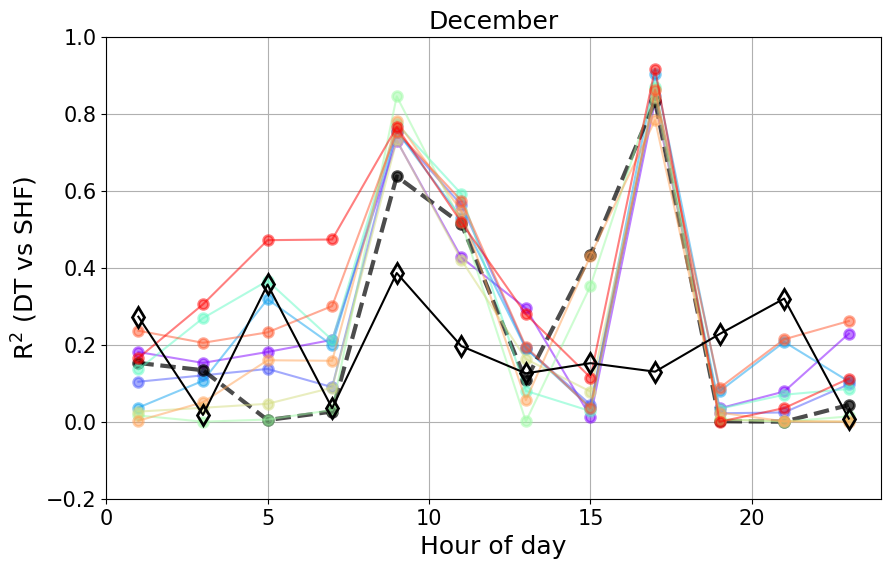

In [25]:
for mon in range(len(month_names)):  
    r2_monthname_lists = []
    for yr in range(10):
        r2_monthname =[]
    
        hours = shf_months_by_yr[mon][yr]['valid_time'].dt.hour
        
        shf_06_08 = shf_months_by_yr[mon][yr].where((hours >= 6) & (hours < 8), drop=True)
        shf_08_10 = shf_months_by_yr[mon][yr].where((hours >= 8) & (hours < 10), drop=True)
        shf_10_12 = shf_months_by_yr[mon][yr].where((hours >= 10) & (hours < 12), drop=True)
        shf_12_14 = shf_months_by_yr[mon][yr].where((hours >= 12) & (hours < 14), drop=True)
        shf_14_16 = shf_months_by_yr[mon][yr].where((hours >= 14) & (hours < 16), drop=True)
        shf_16_18 = shf_months_by_yr[mon][yr].where((hours >= 16) & (hours < 18), drop=True)
        shf_18_20 = shf_months_by_yr[mon][yr].where((hours >= 18) & (hours < 20), drop=True)
        shf_20_22 = shf_months_by_yr[mon][yr].where((hours >= 20) & (hours < 22), drop=True)
        shf_22_24 = shf_months_by_yr[mon][yr].where((hours >= 22) & (hours < 24), drop=True)
        shf_00_02 = shf_months_by_yr[mon][yr].where((hours >= 0) & (hours < 2), drop=True)
        shf_02_04 = shf_months_by_yr[mon][yr].where((hours >= 2) & (hours < 4), drop=True)
        shf_04_06 = shf_months_by_yr[mon][yr].where((hours >= 4) & (hours < 6), drop=True)
        
        dtemp_06_08 = dtemp_months_by_yr[mon][yr].where((hours >= 6) & (hours < 8), drop=True)
        dtemp_08_10 = dtemp_months_by_yr[mon][yr].where((hours >= 8) & (hours < 10), drop=True)
        dtemp_10_12 = dtemp_months_by_yr[mon][yr].where((hours >= 10) & (hours < 12), drop=True)
        dtemp_12_14 = dtemp_months_by_yr[mon][yr].where((hours >= 12) & (hours < 14), drop=True)
        dtemp_14_16 = dtemp_months_by_yr[mon][yr].where((hours >= 14) & (hours < 16), drop=True)
        dtemp_16_18 = dtemp_months_by_yr[mon][yr].where((hours >= 16) & (hours < 18), drop=True)
        dtemp_18_20 = dtemp_months_by_yr[mon][yr].where((hours >= 18) & (hours < 20), drop=True)
        dtemp_20_22 = dtemp_months_by_yr[mon][yr].where((hours >= 20) & (hours < 22), drop=True)
        dtemp_22_24 = dtemp_months_by_yr[mon][yr].where((hours >= 22) & (hours < 24), drop=True)
        dtemp_00_02 = dtemp_months_by_yr[mon][yr].where((hours >= 0) & (hours < 2), drop=True)
        dtemp_02_04 = dtemp_months_by_yr[mon][yr].where((hours >= 2) & (hours < 4), drop=True)
        dtemp_04_06 = dtemp_months_by_yr[mon][yr].where((hours >= 4) & (hours < 6), drop=True)
    
        x=shf_00_02
        y=dtemp_00_02
        x=np.array(x)
        y=np.array(y)
        n, b = np.polyfit(x, y, 1)
        r2 = r2_score(y, (n*x+b))
        r2_monthname.append(r2)
    
        x=shf_02_04
        y=dtemp_02_04
        x=np.array(x)
        y=np.array(y)
        n, b = np.polyfit(x, y, 1)
        r2 = r2_score(y, (n*x+b))
        r2_monthname.append(r2)
    
        x=shf_04_06
        y=dtemp_04_06
        x=np.array(x)
        y=np.array(y)
        n, b = np.polyfit(x, y, 1)
        r2 = r2_score(y, (n*x+b))
        r2_monthname.append(r2)
    
        x=shf_06_08
        y=dtemp_06_08
        x=np.array(x)
        y=np.array(y)
        n, b = np.polyfit(x, y, 1)
        r2 = r2_score(y, (n*x+b))
        r2_monthname.append(r2)
        
        x=shf_08_10
        y=dtemp_08_10
        x=np.array(x)
        y=np.array(y)
        n, b = np.polyfit(x, y, 1)
        r2 = r2_score(y, (n*x+b))
        r2_monthname.append(r2)
        
        x=shf_10_12
        y=dtemp_10_12
        x=np.array(x)
        y=np.array(y)
        n, b = np.polyfit(x, y, 1)
        r2 = r2_score(y, (n*x+b))
        r2_monthname.append(r2)
    
        x=shf_12_14
        y=dtemp_12_14
        x=np.array(x)
        y=np.array(y)
        n, b = np.polyfit(x, y, 1)
        r2 = r2_score(y, (n*x+b))
        r2_monthname.append(r2)
    
        x=shf_14_16
        y=dtemp_14_16
        x=np.array(x)
        y=np.array(y)
        n, b = np.polyfit(x, y, 1)
        r2 = r2_score(y, (n*x+b))
        r2_monthname.append(r2)
    
        x=shf_16_18
        y=dtemp_16_18
        x=np.array(x)
        y=np.array(y)
        n, b = np.polyfit(x, y, 1)
        r2 = r2_score(y, (n*x+b))
        r2_monthname.append(r2)
    
        x=shf_18_20
        y=dtemp_18_20
        x=np.array(x)
        y=np.array(y)
        n, b = np.polyfit(x, y, 1)
        r2 = r2_score(y, (n*x+b))
        r2_monthname.append(r2)
    
        x=shf_20_22
        y=dtemp_20_22
        x=np.array(x)
        y=np.array(y)
        n, b = np.polyfit(x, y, 1)
        r2 = r2_score(y, (n*x+b))
        r2_monthname.append(r2)
    
        x=shf_22_24
        y=dtemp_22_24
        x=np.array(x)
        y=np.array(y)
        n, b = np.polyfit(x, y, 1)
        r2 = r2_score(y, (n*x+b))
        r2_monthname.append(r2)
    
        r2_monthname_lists.append(r2_monthname)

    plt.figure(figsize=(10,6))
    cmap = cm.rainbow
    norm = mcolors.Normalize(vmin=min(years), vmax=max(years))
    edgecolors = [None,None,None,'black',None,None,None,None,None,None]
    for i, year in enumerate(years[:3]):
        plt.plot(slot_hour, r2_monthname_lists[i],
                 color=cmap(norm(year)),   # one color per year
                 marker='o', markerfacecolor=cmap(norm(year)),markeredgecolor=edgecolors[i],markeredgewidth=2,
                 ms=7, alpha=0.5,
                 label=str(year))
    plt.plot(slot_hour, r2_monthname_lists[3],
                 color='black',
                 linestyle='--', lw=3,
                 marker='o', markerfacecolor=None, markeredgewidth=2,
                 ms=7, alpha=0.7,
                 label='2017')
    for i, year in enumerate(years[4:], start=4):
        plt.plot(slot_hour, r2_monthname_lists[i],
                 color=cmap(norm(year)),   # one color per year
                 marker='o', markerfacecolor=cmap(norm(year)), markeredgecolor=edgecolors[i],markeredgewidth=2,
                 ms=7, alpha=0.5,
                 label=str(year))
    plt.plot(slot_hour, r2_monthwise_lists[mon], label='Obs, 2017',color='black',marker='d',markerfacecolor='None',markeredgecolor='black',ms=10,markeredgewidth=2)
    plt.title(f'{month_names[mon]}', fontsize=18)
    plt.xlabel('Hour of day', fontsize=18)
    plt.ylabel('R$^2$ (DT vs SHF)', fontsize=18)
    plt.xlim(0, 24)
    plt.ylim(-0.2, 1)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    #plt.legend(fontsize=10)
    plt.grid(True)
    
    plt.savefig(f"/home/gopika/Bela/GISE/dpi_paper_plots/r2_diurnal/DT/{month_names[mon]}_R2_diurnal.png", dpi=600, bbox_inches="tight")
    plt.show()


### Comparing r2 dirunal cycles for SHF with U and DT

In [26]:
r2_time_jan_o = [0.7158257990511296, 0.4545043700013036, 0.3471158456073137, 0.029221893807498067, 0.05522342138751046, 0.20362636511029153, 0.14280540642450745, 0.0386802634542478, 0.09695888492782667, 0.7284714810091321, 0.6803116684023016, 0.5387842817202672]
r2_time_feb_o = [0.5427289740478373, 0.015522728325973123, 0.0008544246002798461, 0.6236545829768618, 0.06503617020261421, 0.15206822620919347, 0.3436083122926197, 0.004725724603475423, 0.001583481426203348, 0.05941400662356833, 0.5160743306590367, 0.5326266538086695]
r2_time_mar_o = [0.4640749428235963, 0.6329002052723014, 0.6681845960036297, 0.5740191917179824, 0.142409801766602, 0.10507020538687806, 0.2914687264123931, 0.13356740338120554, 0.08983830276072569, 0.10668349572502822, 0.5322840814136437, 0.6080324599157974]
r2_time_apr_o = [0.49659079095426073, 0.3964099914828262, 0.5986679851723271, 0.006349385951532338, 0.19966921162073392, 0.3300141039250786, 0.33078778750970905, 0.1278661272689281, 0.07481459121465472, 0.03038669018924356, 0.5261356520366682, 0.4555338272747824]
r2_time_may_o = [0.00080483830714706,0.04384621599557392,0.05396508423708224,0.24069850871502407,0.29868706581002613,0.3724772163863782,0.5256146904322654,0.06028242454311561,0.030585744448364593,0.19135049547140703,6.394039877566371e-07,0.04703901446]
r2_time_jun_o = [0.003919153212931459, 0.016589293035037533, 0.0015382328991137006, 0.31587478717961326, 0.35387496451466893, 0.2501134993557259, 0.3889750908610925, 0.1243695155070823, 0.11834586386861123, 0.10529901185339396, 0.014758269257274637, 0.04764166408194115]
r2_time_jul_o = [0.01924259703677267, 0.048437935748523286, 0.013538620075276286, 0.23842078265306543, 0.23986445754408214, 0.4149629906627793, 0.46350809160183837, 0.4677125639985448, 0.1762236562955085, 0.12958809705336827, 0.03679411744069516, 0.015775246103798657]
r2_time_aug_o = [0.13895253325538548, 0.19769482166636398, 0.1472250947097944, 0.03061091634990043, 0.01932709626540774, 0.0080629214390453, 0.004946749299827857, 0.0066133520950888425, 0.0251748673478277, 0.11562564326098457, 0.03880888877617539, 0.020979597725929056]
r2_time_sep_o = [0.31863506288547483, 0.382492750626672, 0.6149351154959682, 9.71123469432067e-05, 0.017258309012625705, 0.000793314559097702, 0.006888650966775711, 0.006648856301498696, 0.051404593669874155, 0.17094402424892774, 0.0001204625172358531, 0.052046494950444]
r2_time_oct_o = [0.3578426295940802, 0.499426628645778, 0.3302585315898189, 0.28657872389074057, 0.04850257546267234, 0.1590794602477864, 0.23759839713999353, 0.17550658339568825, 0.16209949799517043, 0.3811473126606406, 0.3938700556798901, 0.3651396671045841]
r2_time_nov_o = [0.15312826328162243, 0.44857798107499147, 0.24912070497326422, 0.2868269818937931, 0.006029909935086897, 0.015372225318788124, 0.1364097333898897, 0.07785394179735405, 0.012595687625002627, 0.5949893338275449, 0.677242284576646, 0.5734541414419919]
r2_time_dec_o = [0.40523277462732343,0.11223059837339844,0.005909329633781102,0.004252530961252443,2.508855981286917e-05,0.1493062599335614,0.08280524973501224,0.014580863633631536,0.08119782334155923,0.7875369345414484,0.48864451328184266,0.3868329253]

r2_shf_u = [r2_time_jan_o, r2_time_feb_o, r2_time_mar_o, r2_time_apr_o, r2_time_may_o, r2_time_jun_o,
           r2_time_jul_o, r2_time_aug_o, r2_time_sep_o, r2_time_oct_o, r2_time_nov_o, r2_time_dec_o]

r2_shf_dt = r2_monthwise_lists


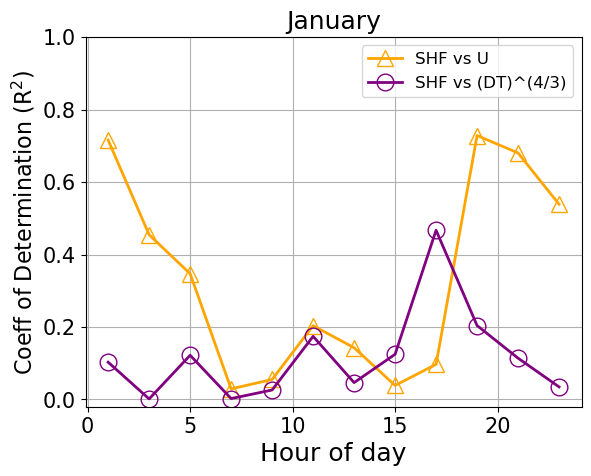

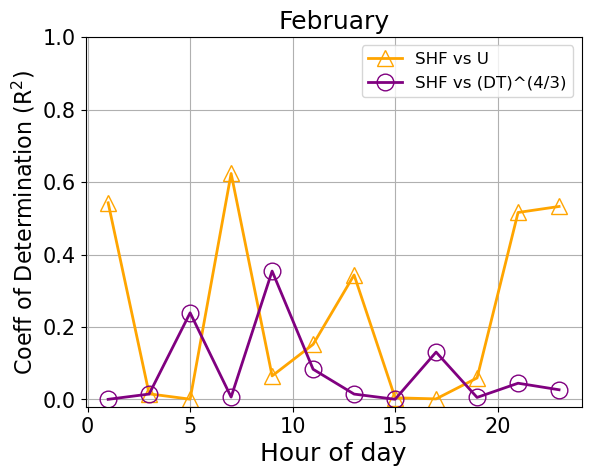

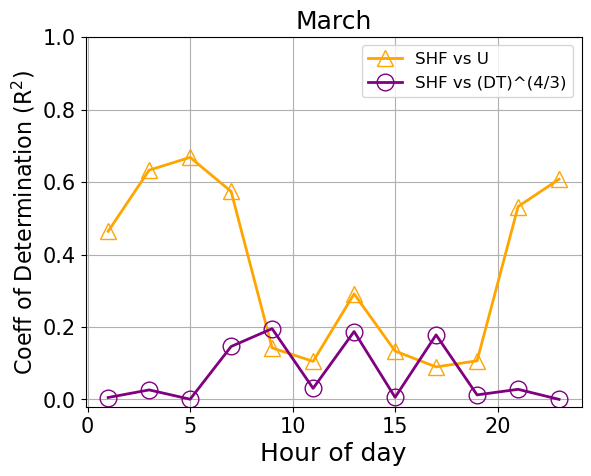

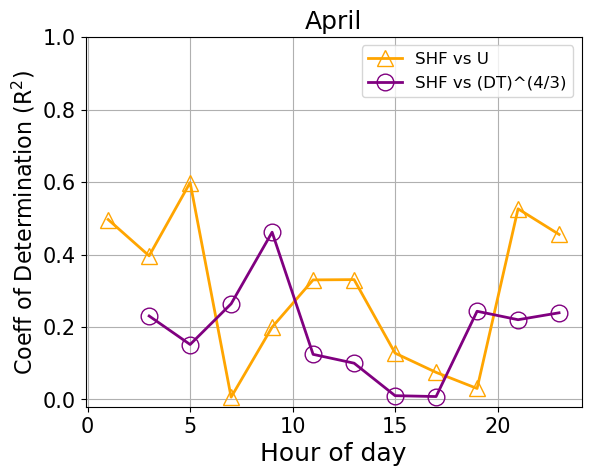

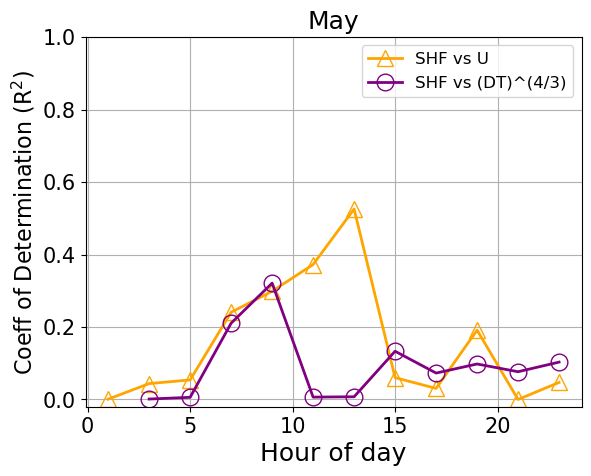

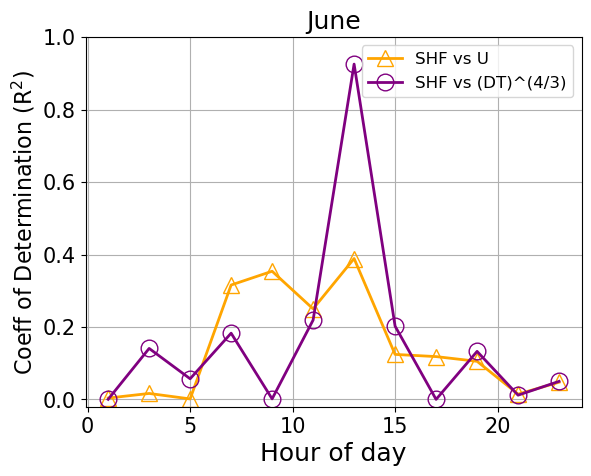

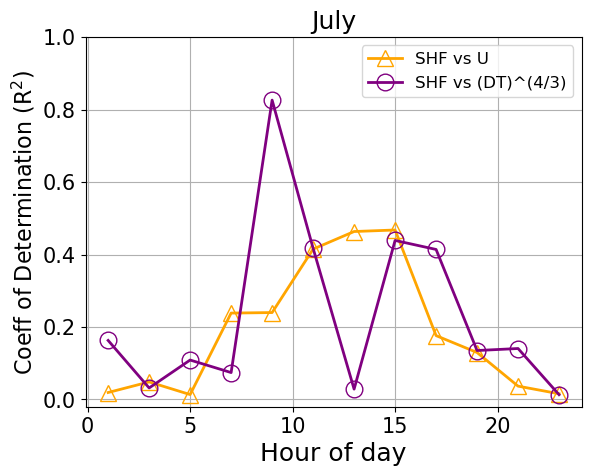

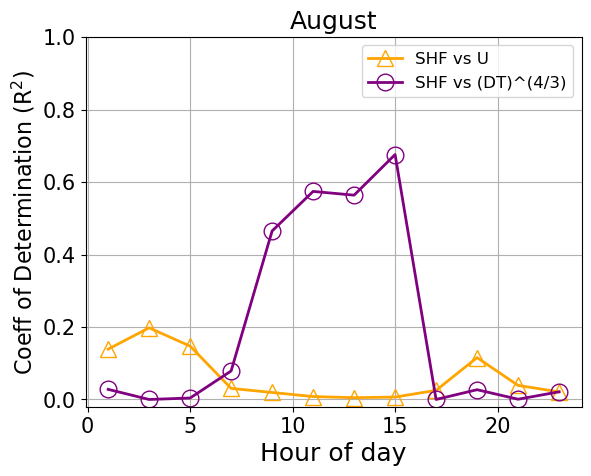

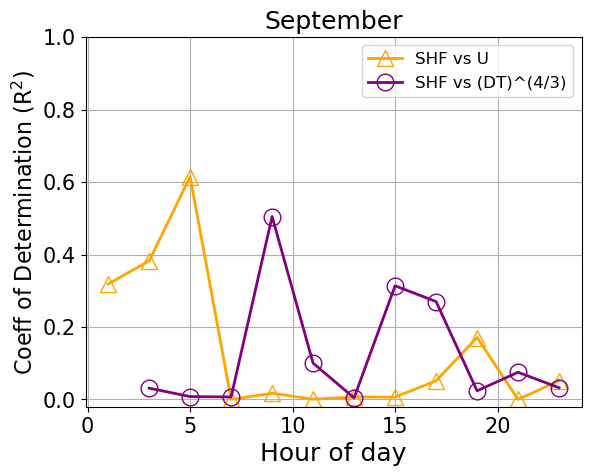

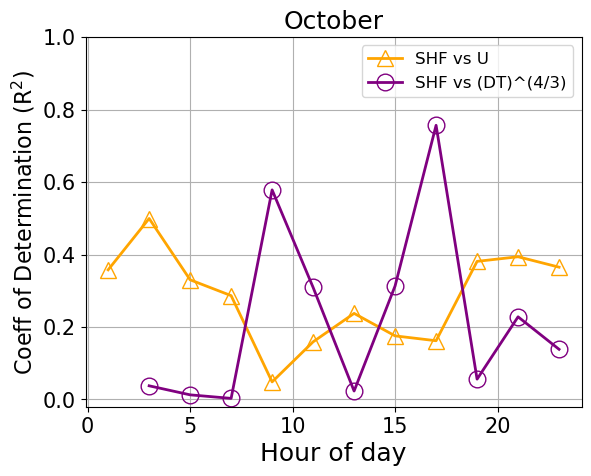

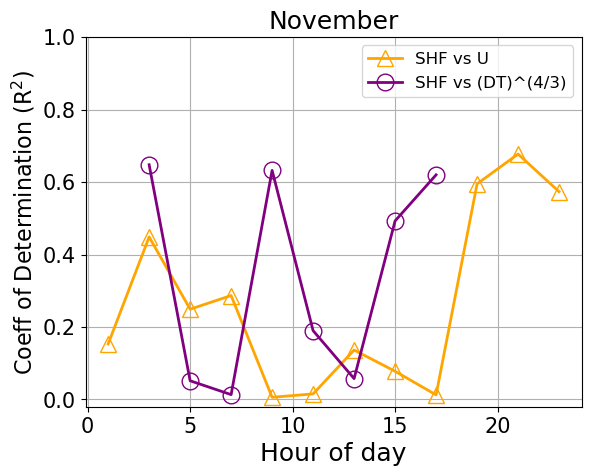

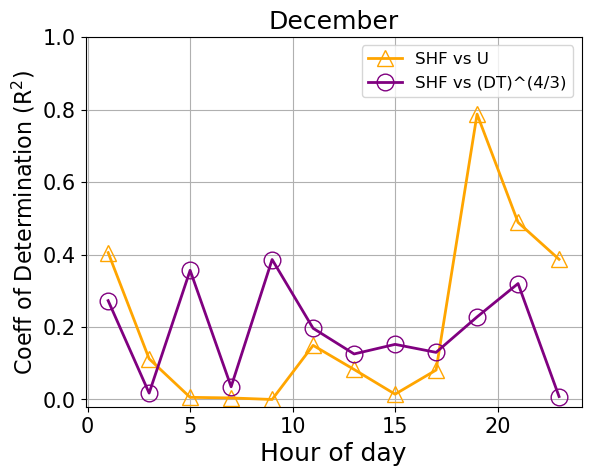

In [28]:
for i in range(12):
    plt.figure()
    plt.plot(slot_hour, r2_shf_u[i], marker='^', ms=12, markerfacecolor='none', color='orange', linewidth=2, label='SHF vs U')
    plt.plot(slot_hour, r2_shf_dt[i], marker='o', ms=12, markerfacecolor='none',color='purple', linewidth=2, label='SHF vs (DT)^(4/3)')
    plt.ylim(-0.02, 1)
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.xlabel("Hour of day", fontsize=18)
    plt.ylabel("Coeff of Determination (R$^2$)", fontsize=16)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(f"{month_names[i]}", fontsize=18)
    plt.savefig(f"/home/gopika/Bela/GISE/dpi_paper_plots/r2_diurnal/complementary/{month_names[i]}_R2_diurnal.png", dpi=600, bbox_inches="tight")
    plt.show()
    